# <b>Introduction to Statistical Learning, 2nd Edition</b>
## by James, Witten, Hastie, Tibshirani

### Notes by Melis Tekant

## Chapter 6  - Linear Model Selection and Regularization

In [129]:
import pandas as pd
import numpy as np
import matplotlib as mpl
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
import random
import scipy.stats as st
import itertools

Linear models are often quite competitive in real-world problems, and have the advantage of interpretability. These models can be improved by using fitting procedures other than least squares, such as subset selection, shrinkage, and dimension reduction.

Subset selection:

- Best subset selection: fit least squares regression for each combination of p predictors (leading to $2^p$ models) and identify the best. Do this by setting $M_0$ as the null model with no predictors, then for k = 1,2,...,p, fit all ${p \choose k}$ models with k predictors, pick the best among them (one which has the lowest RSS), and label it $M_k$. (For logistic regression, instead of RSS, $\textit{deviance} = -2ln(L)$ is used.) Then select the best $M_k$ using cross-validated prediction error, $C_p$, AIC, BIC, or adjusted R-squared. This way, the number of stored models reduces to p+1. This method is highly computationally intensive, so for large values of p, computational shortcuts (branch-and-bound techniques) can be used to eliminate some choices, or alternative methods that are more computationally efficient can be used. 

AIC: Akaike information criterion, $\propto C_p$, Mallows score here. It is a relative estimator, where the lower the value is, the better the model is. It is often used for time series data. 
AIC $ = -2ln(L) + 2k$, where the $ln(L)$ term denotes the log-likelihood, and $k$ is the number of parameters, acting as a penalty for the AIC value.

(Note: this definition differs from the definition in the book: $C_p = \frac{1}{n}(RSS + 2k \hat \sigma^2)$, yet they are equivalent for a Linear model, given that the residuals are normally distributed.  

This can be shown via the following: Given the response $y = \omega X + \epsilon$, where $\epsilon \sim N(0,\sigma)$, the maxmimum likelihood is calculated by 

$$ L = \frac{1}{(2 \pi)^{N/2} \sigma^N} e^{-\frac{\sum(y-\omega X)^2}{2\sigma^2}}.$$

Therefore, $ln(L) = A + (-\frac{\sum(y-\omega X)^2}{2 \sigma^2})$, where A is a constant involving N and $\sigma$. 

Since $C_p$ is a relative estimator, it can be scaled, and constants can be added or removed from it, given that the process is done for each value that will be compared. 

Scaling the definition of $C_p$ in the text by $n/\hat \sigma^2$ gives equivalent results to the above definition with an additional constant and a scaling factor.)

BIC: Bayesian information criterion. Similar to AIC, but a different penalty term for complexity.
BIC $= -2ln(L) + ln(n)k$ $(\propto \frac{1}{n}(RSS+log(n)k\hat\sigma^2)$, where n is the number of data points. For n>7, this model places a larger penalty for k, so it typically selects for smaller number of predictors when compared to AIC. 

Adjusted R-squared: R-squared model that has been modified for the number of predictors, to penalize increasing k to prevent overfitting. 

$R^2 = 1- \frac{RSS}{TSS}$, where TSS = $\sum(y_i-\bar y)^2$.

Adjusted $R^2 = 1-\frac{RSS/(n-k-1)}{TSS/(n-1)}$.

Alternatively, test error can be estimated using validation set and cross-validation methods, which make fewer assumptions about the true model, and can be used even when $\sigma$ or k is hard to estimate.

In [47]:
credit = pd.read_csv('/Users/melistekant/Documents/Python Projects/ISLR2/Credit.csv')
credit.columns

Index(['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Own',
       'Student', 'Married', 'Region', 'Balance'],
      dtype='object')

In [48]:
# Separate Region into 2 dummy variables

dummy_south = np.zeros(len(credit.Region))
dummy_west = np.zeros(len(credit.Region))
dummy_south[credit.Region == 'South'] = 1 
dummy_west[credit.Region == 'West'] = 1
credit2 = credit.drop(columns = 'Region', axis =1)
credit2['West'] = dummy_west.astype('int')
credit2['South'] = dummy_south.astype('int')

yndict = {'Yes':1, 'No': 0}
credit2[['Own','Student','Married']] = credit2[{'Own','Student','Married'}].applymap(lambda x: yndict[x])
credit2.head()

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Balance,West,South
0,14.891,3606,283,2,34,11,1,0,0,333,0,1
1,106.025,6645,483,3,82,15,1,1,1,903,1,0
2,104.593,7075,514,4,71,11,0,0,0,580,1,0
3,148.924,9504,681,3,36,11,0,0,1,964,1,0
4,55.882,4897,357,2,68,16,1,0,0,331,0,1


In [89]:
model = LinearRegression()

def RSS_Rsq_Eval(X,y,k):
    RSS_i = []
    features = []
    Rsq_i = []
    for combo in itertools.combinations(X.columns,k):
        model.fit(X[list(combo)],y)
        ypred = model.predict(X[list(combo)])
        RSS = mean_squared_error(y,ypred) *len(y)
        RSS_i.append(RSS)
        features.append(list(combo))
        R_sq = model.score(X[list(combo)],y)
        Rsq_i.append(R_sq)  
    return RSS_i, Rsq_i, features

In [102]:
y = credit2.Balance
X = credit2.drop(columns = 'Balance',axis=1)
knum = np.arange(1,len(credit2.columns))
df = pd.DataFrame(columns = ['k','RSS','R_sq','Features'])

for i in knum:
    RSS_i,Rsq_i,feats = RSS_Rsq_Eval(X,y,i)
    df_mini = pd.DataFrame({'k':i,'RSS':RSS_i,'R_sq':Rsq_i,'Features':feats})
    df = pd.concat([df,df_mini])

df.reset_index();

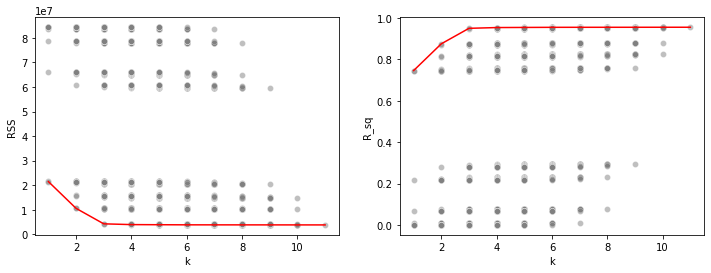

In [171]:
plt.subplots(figsize=(12,4))
plt.subplot(1,2,1)
sns.scatterplot(x = 'k', y = 'RSS', data = df, color = 'gray', alpha = 0.5)
RSS_min = df.groupby('k')['RSS'].apply(min)
plt.plot(RSS_min.index,RSS_min.values, c = 'r')

plt.subplot(1,2,2)
sns.scatterplot(x = 'k', y = 'R_sq', data = df, color = 'gray', alpha = 0.5)
Rsq_max = df.groupby('k')['R_sq'].apply(max)
plt.plot(Rsq_max.index,Rsq_max.values, c= 'r');


In [132]:
# Let's repeat above steps for the other metrics: C_p, BIC, 
# and adjusted R-squared, using the definitions in the textbook.

n = len(credit2)
sigma_est = min(RSS_min)/(n-max(knum)-1)

df['Cp'] = (1/n)*(df.RSS + 2* df.k *sigma_est)
df['BIC'] = (1/n)*(df.RSS + np.log(n)*df.k*sigma_est)
df['Adj_Rsq'] = 1- (df.RSS/(n-df.k-1))/(df.RSS/(1-df.R_sq) / (n-1))

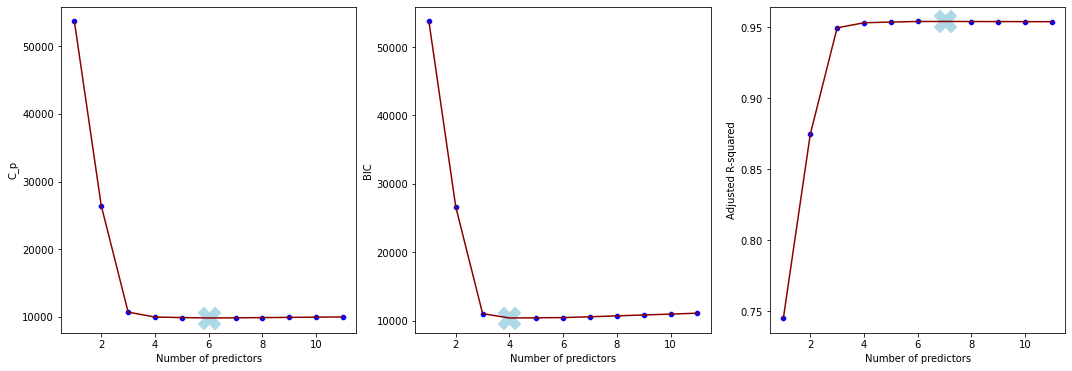

In [170]:
Cp_min = df.groupby('k')['Cp'].apply(min)
BIC_min = df.groupby('k')['BIC'].apply(min)
Adj_Rsq_max = df.groupby('k')['Adj_Rsq'].apply(max)

plt.subplots(figsize=(18,6))
plt.subplot(1,3,1)
sns.scatterplot(x = Cp_min.index,y = Cp_min.values,color='blue')
sns.lineplot(x = Cp_min.index,y = Cp_min.values,color='darkred')
plt.scatter(x = Cp_min.idxmin(), y = Cp_min.min(), marker = 'X', c = 'lightblue', s = 500)
plt.xlabel('Number of predictors')
plt.ylabel('C_p')

plt.subplot(1,3,2)
sns.scatterplot(x = BIC_min.index, y = BIC_min.values,color='blue')
sns.lineplot(x = BIC_min.index,y = BIC_min.values,color='darkred')
plt.scatter(x = BIC_min.idxmin(), y = BIC_min.min(), marker = 'X', c = 'lightblue', s = 500)

plt.ylabel('BIC')
plt.xlabel('Number of predictors')

plt.subplot(1,3,3)
sns.scatterplot(x = Adj_Rsq_max.index, y = Adj_Rsq_max.values,color='blue')
sns.lineplot(x = Adj_Rsq_max.index,y = Adj_Rsq_max.values,color='darkred')
plt.scatter(x = Adj_Rsq_max.idxmax(), y = Adj_Rsq_max.max(), marker = 'X', c = 'lightblue', s = 500)
plt.ylabel('Adjusted R-squared')
plt.xlabel('Number of predictors');


If the error vs. k graph is quite flat, use the 'one-standard-error rule': calculate standard error and estimate MSE for each k. Select the simplest (smallest k) model for which test error is within one standard error of the lowest error value. 

- Stepwise selection: For large p where best subset selection might not be usable, stepwise methods, which test much more restricted models, can be used.
    
     Forward stepwise selection: Start with no predictors ($M_0$) and add one predictor at a time (the one that gives the greatest additional improvement to the fit, measured by lowest RSS or highest R-squared, call $M_k$ for k predictors in the model) until all are in the model. This leads to $1+p(p+1)/2$ fits instead of $2^p$. Select the best $M_k$ using cross-validated prediction error, AIC, BIC, or adjusted R-squared. 
     
     Backward stepwise selection: Similar to forward stewpsie selection, but start with all predictors, and remove predictors one at a time, selecting the best k-1 predictors (given by lowest RSS or highest R-squared value) at each step, then find best $M_k$ by one of the metrics outlined above. This method requires n>p, while forward stepwise selection does not. 
     
     Hybrid approaches: Predictors are added to the model, but can also be removed, if they do not provide improvement in the new fit. This approach tries to marry the subset selection model with the computational advantages of stepwise selection methods. 

In [358]:
# Forward stepwise

stepwise_df = pd.DataFrame(columns = ['k','Rsq','features'])

for k in knum:
    feats_k = []
    Rsq_k = []
    if k!= knum[0]: 
        Xset = X.drop(columns = stepwise_df['features'].iloc[-1],axis=1)
    else:
        Xset = X
    for i in Xset.columns:
        Xchoose = Xset[[i]]
        if k != knum[0]:
            #Xsubset_i = pd.concat([X[[stepwise_df['features'].iloc[-1]]],Xchoose],axis =1)
            Xsubset_i = pd.concat([Xsubset,Xchoose],axis=1)
        else:
            Xsubset_i = Xchoose
        model.fit(Xsubset_i,y)
        Rsq_i = model.score(Xsubset_i,y)
        Rsq_k.append(Rsq_i)
        feats_k.append(Xsubset_i.columns)
    Rsqmax = max(Rsq_k)
    Ridx = Rsq_k.index(Rsqmax)
    stepwise_df_k = pd.DataFrame({'k': k, 'Rsq': Rsqmax, 'features':[feats_k[Ridx].tolist()]})
    if k == knum[0]:
        stepwise_df = stepwise_df_k
        Xsubset = X[feats_k[Ridx]]
    else:
        stepwise_df = pd.concat([stepwise_df,stepwise_df_k])
        Xsubset = pd.concat([Xsubset,X[feats_k[Ridx][-1]]],axis=1)

        
print('Forward stepwise method:')        
print(stepwise_df[0:4])

print('')

feats = []
for i in Rsq_max.values:
    feats.append([df['Features'][df['R_sq'] == i]])

best_df = pd.DataFrame({'k':Rsq_max.index, 'Rsq': Rsq_max.values, 'features':feats})
    
print('Best subset method:')

print(best_df[0:4])


Forward stepwise method:
   k       Rsq                          features
0  1  0.745848                          [Rating]
0  2  0.875118                  [Rating, Income]
0  3  0.949879         [Rating, Income, Student]
0  4  0.952188  [Rating, Income, Student, Limit]

Best subset method:
   k       Rsq                             features
0  1  0.745848                         [[[Rating]]]
1  2  0.875118                 [[[Income, Rating]]]
2  3  0.949879        [[[Income, Rating, Student]]]
3  4  0.953580  [[[Income, Limit, Cards, Student]]]


Instead of selecting a subset of predictors to fit the model, we can use all p predictors with a technique that constrains or regularizes the coefficients (shrink them towards 0). The best known examples of this are ridge regression and lasso. 

Ridge Regression:

Instead of fitting by maximizing residual sum of squares (RSS) values, the coefficients are chosen such that they minimize 

$$ \sum_{i=1}^n (y_i-\beta_0 - \sum_{j=1}^p \beta_j x_{ij})^2 + \lambda \sum_{j=1}^p \beta_j^2 = RSS + \lambda \sum_{j=1}^p \beta_j^2 $$

where $\lambda$ is a tuning parameter, and $ \lambda \sum_{j=1}^p \beta_j^2 $ is the shrinkage penalty. For small $\beta_j$, this term is small, and leads to the shrinking of those terms. $\lambda$ is a knob for controlling the strength of this penalty compared to RSS. 

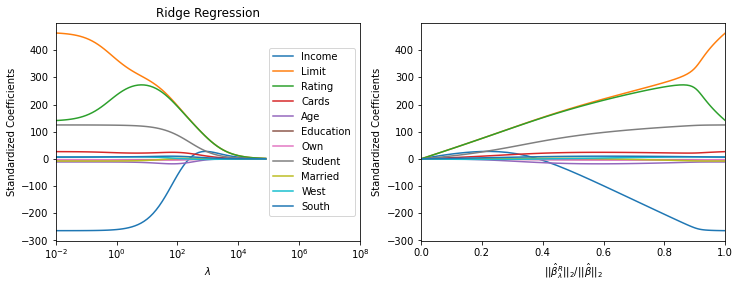

In [651]:
X = credit2.drop(columns = 'Balance',axis=1)

# We first apply standardized scaler to the predictor values so that they're all centered around zero
# and have a deviation of one.

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
y = credit2.Balance
X_train_scale, X_test_scale, y_train, y_test = train_test_split(Xscale,y,test_size=0.25,random_state=42)
loglams = np.arange(-2,5,0.1)
lams = 10**loglams
coeffs = np.zeros((len(lams),len(X.columns)))
ypreds = np.zeros((len(X_test_scale), len(lams)))
y_all_preds = np.zeros((len(Xscale), len(lams)))


from sklearn.linear_model import Ridge

for lidx, lam in enumerate(lams):
    ridge = Ridge(alpha = lam)
    ridge.fit(X_train_scale,y_train)
    coeffs[lidx,:] = ridge.coef_
    ypreds[:,lidx] = ridge.predict(X_test_scale)
    y_all_preds[:,lidx] = ridge.predict(Xscale)

    
plt.subplots(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogx(lams,coeffs)
plt.xlim(1E-2,1E8)
plt.legend(list(X.columns),loc='center right')
plt.xlabel('$\\lambda$')
plt.ylabel('Standardized Coefficients')
plt.title('Ridge Regression')

plt.subplot(1,2,2)
plt.plot((np.sum(coeffs**2,axis=1)/np.sum(coeffs[0,:]**2))**0.5,coeffs)
plt.xlim(0,1)
plt.xlabel('$||\\hat \\beta_{\lambda}^R||_2/||\\hat \\beta||_2$')
plt.ylabel('Standardized Coefficients');
    

As the penalty coefficient is increased, the variance of the fit decreases, but bias increases.(bias-variance trade-off). 

In [683]:
# Return to this code later -- there might be an error.

# from sklearn.metrics import mean_squared_error

# bias = np.zeros(len(lams))
# test_mse = np.zeros(len(lams))
# var = np.zeros(len(lams))
# for i in range(len(lams)):
#     test_mse[i] = mean_squared_error(y_test,ypreds[:,i])
#     bias[i] = np.mean(y_all_preds[:,i]-y)
#     var[i] = np.var(y_all_preds[:,i])

# plt.subplots(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.semilogx(lams,var,color='teal',label='Variance')
# plt.semilogx(lams,bias**2,color='k',label='Squared Bias')
# plt.semilogx(lams,test_mse,color='pink',label='Test MSE')
# plt.xlabel('$\\lambda$')
# plt.ylabel('Mean Squared Error')
# plt.legend()

# plt.subplot(1,2,2)
# plt.plot((np.sum(coeffs**2,axis=1)/np.sum(coeffs[0,:]**2))**0.5,var,color='teal',label='Variance')
# plt.plot((np.sum(coeffs**2,axis=1)/np.sum(coeffs[0,:]**2))**0.5,bias**2,color='k',label='Squared Bias')
# plt.plot((np.sum(coeffs**2,axis=1)/np.sum(coeffs[0,:]**2))**0.5,test_mse,color='pink',label='Test Mean Squared Error')
# plt.xlim(0,1)
# plt.xlabel('$||\\hat \\beta_{\lambda}^R||_2/||\\hat \\beta||_2$')
# plt.ylabel('Mean Squared Error');


Lasso Regression:

Lasso adds a penalty that is linear to the coefficients, instead of quadratic, as in the case of Ridge Regression. This method aims to minimize the quantity

$$ \sum_{i=1}^n (y_i-\beta_0 - \sum_{j=1}^p \beta_j x_{ij})^2 + \lambda \sum_{j=1}^p |\beta_j| = RSS + \lambda \sum_{j=1}^p |\beta_j|. $$

Unlike Ridge Regression ($\ell_2$ penalty), which shrinks coefficients, but never sets them to zero, which may create model interpretability issues, Lasso Regression ($\ell_1$ penalty) does set some coefficients to zero (given that $\lambda$ is sufficiently large), yielding sparse models. This is beneficial in understanding which parameters are the most important ones (variable selection). 

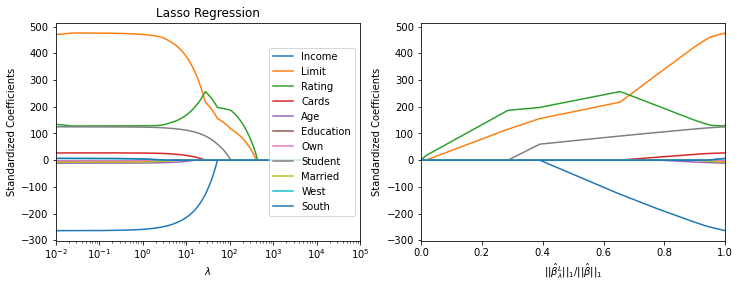

In [692]:
loglams = np.arange(-2,4,0.01)
lams = 10**loglams
coeffs_lasso = np.zeros((len(lams),len(X.columns)))
ypreds_lasso = np.zeros((len(X_test_scale), len(lams)))
y_all_preds_lasso = np.zeros((len(Xscale), len(lams)))

from sklearn.linear_model import Lasso

for lidx, lam in enumerate(lams):
    lasso = Lasso(alpha = lam)
    lasso.fit(X_train_scale,y_train)
    coeffs_lasso[lidx,:] = lasso.coef_
    ypreds_lasso[:,lidx] = lasso.predict(X_test_scale)
    y_all_preds_lasso[:,lidx] = lasso.predict(Xscale)

    
plt.subplots(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogx(lams,coeffs_lasso)
plt.xlim(1E-2,100000)
plt.legend(list(X.columns),loc='center right')
plt.xlabel('$\\lambda$')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Regression')

plt.subplot(1,2,2)
plt.plot((np.sum(abs(coeffs_lasso),axis=1)/np.sum(abs(coeffs_lasso[0,:]))),coeffs_lasso)
plt.xlim(0,1)
plt.xlabel('$||\\hat \\beta_{\lambda}^L||_1/||\\hat \\beta||_1$')
plt.ylabel('Standardized Coefficients');
    